In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import numpy as np
import os
import sys
import pandas as pd
import func
import matplotlib.pyplot as plt
import tikzplotlib
from skimage.util import random_noise
from skimage import io, filters, img_as_ubyte
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from params import dresden_images_root, patches_root, patches_db_path, train_csv_path, \
post_root, compr_img, noise_img, blur_img

In [4]:
train_db = pd.read_csv(train_csv_path)
model_list = np.unique(train_db['brand_model']) 
img_path = [] # path of the images
file_name = [] # file name of the images
img_num = [] # number of images of each camera
label_list = []
compr_path = [] # path of compressed images
noise_path = []
blur_path = []

for model in model_list: 
    tmp = os.listdir(os.path.join(patches_root, 'test', model))
    img_num.append(len(tmp))
    file_name += tmp
    img_path += [os.path.join(patches_root, 'test', model, img) for img in tmp]
    # create dir for each camera for every post-processing technique
    for proc in [compr_img, noise_img, blur_img]:
        path = os.path.join(proc, model)
        if not os.path.exists(path):
            os.makedirs(path)
    
for i in range(len(img_num)):
    label_list += [model_list[i]]* img_num[i]

for img, label in zip(file_name, label_list):
    compr_path += [os.path.join(compr_img, label, img)]
    noise_path += [os.path.join(noise_img, label, img)]
    blur_path += [os.path.join(blur_img, label, img)]
    
model_list = [m.replace("_", " ") for m in model_list]

In [5]:
# Compress to JPEG, QF = 70
for img, path in zip(img_path, compr_path):
    if not os.path.exists(path):          
        im = Image.open(img)
        im.save(path, 'JPEG', quality=70, optimize=True)

In [6]:
# Adding Gaussian Noise
mean = 0
sigma = 2/255
height, width = (256, 256)

for img, path in zip(img_path, noise_path):
    if not os.path.exists(path): 
        image = io.imread(img)
        noisy = random_noise(image, mode='gaussian', mean=0, var=sigma**2)
        io.imsave(path, img_as_ubyte(noisy), check_contrast=False)

In [7]:
# Adding Gaussian Blur
for img, path in zip(img_path, blur_path):
    if not os.path.exists(path): 
        image = io.imread(img)
        blur = filters.gaussian(image, sigma=1.1, truncate=2.0)
        io.imsave(path, img_as_ubyte(blur), check_contrast=False)

In [8]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('./model.h5')

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.0004)

model.compile(
    optimizer=sgd, 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

# Create the Generator
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

Found 11775 images belonging to 3 classes.

It tooks 22 seconds

columns are predictions, index are ground truth



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,836,249,354
Nikon D200,68,1758,60
Olympus mju-1050SW,484,495,2096


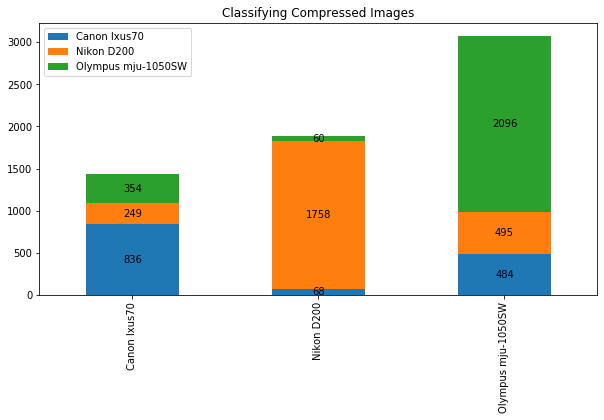

In [9]:
# Read the positive test samples.
compr_generator = test_data_gen.flow_from_directory(
                  directory = r"./post/compr/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# print('\n# Evaluate on test data')
# results = model.evaluate(compr_generator)

hist, conf, pred_labels, real_labels = func.evaluate(model_list, compr_generator, model, index=model_list, columns=model_list, 
                                   title='Classifying Compressed Images', num_batch=100, tex=True)

The mean of the confidence is: 



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,0.948431,0.757651,0.791218
Nikon D200,0.826271,0.970757,0.748564
Olympus mju-1050SW,0.814468,0.784488,0.894988


The standard deviation of the confidence is: 



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,0.014579,0.026733,0.025102
Nikon D200,0.030221,0.005778,0.024254
Olympus mju-1050SW,0.029913,0.028986,0.020614


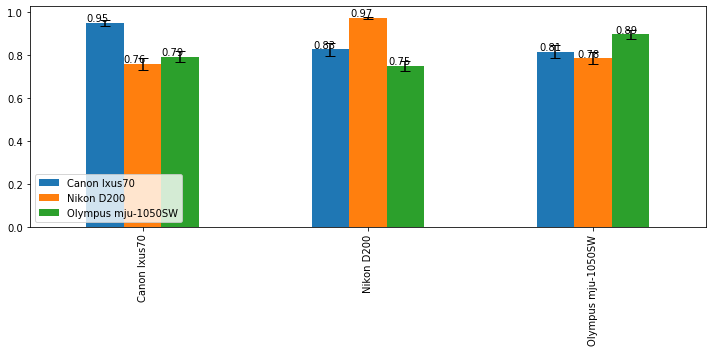

In [10]:
tex = True
df_mean, df_error = func.mean_error(conf, pred_labels, real_labels,
                                    real_model=model_list, pred_model=model_list)
if tex:
    ax = df_mean.plot.bar(yerr=df_error, capsize=5, figsize=(10, 5))
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.008, p.get_height() * 1.008))
    tikzplotlib.save("test_conf.tex")
    plt.tight_layout()
    
else:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    df_mean.plot.bar(yerr=df_error, ax=axes[0,0], capsize=4)
    graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}
    func.plot_conf(conf, pred_labels, real_labels, graph, real_model=model_list, pred_model=model_list)
    
plt.tight_layout()

Found 11775 images belonging to 3 classes.

It tooks 81 seconds

columns are predictions, index are ground truth



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,1364,7,0
Nikon D200,871,1106,0
Olympus mju-1050SW,2315,19,718


The mean of the confidence is: 



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,0.997326,0.771356,0.000000
Nikon D200,0.898575,0.898064,0.000000
Olympus mju-1050SW,0.966319,0.713302,0.924066


The standard deviation of the confidence is: 



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,0.000663,0.015097,0.000000
Nikon D200,0.019657,0.017955,0.000000
Olympus mju-1050SW,0.007175,0.034221,0.016115


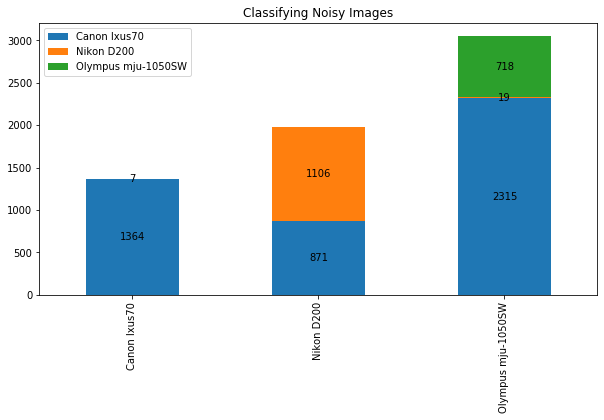

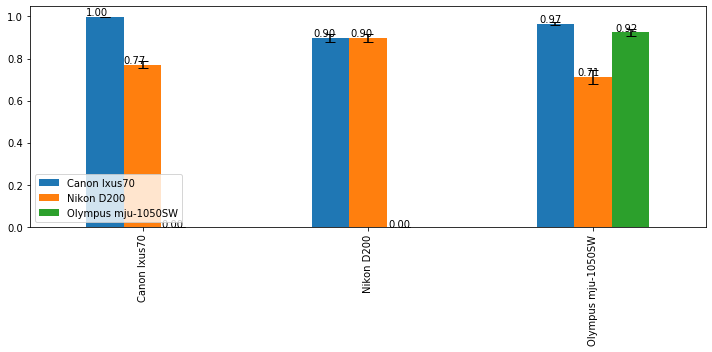

In [12]:
# Read the positive test samples.
noise_generator = test_data_gen.flow_from_directory(
                  directory = r"./post/noise/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# print('\n# Evaluate on test data')
# results = model.evaluate(noise_generator)

hist, conf, pred_labels, real_labels = func.evaluate(model_list, noise_generator, model, index=model_list, columns=model_list, 
                                   title='Classifying Noisy Images', num_batch=100, tex=True)

tex = True
df_mean, df_error = func.mean_error(conf, pred_labels, real_labels,
                                    real_model=model_list, pred_model=model_list)
if tex:
    ax = df_mean.plot.bar(yerr=df_error, capsize=5, figsize=(10, 5))
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.008, p.get_height() * 1.008))
    tikzplotlib.save("test_conf.tex")    
else:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    ax = df_mean.plot.bar(yerr=df_error, ax=axes[0,0], capsize=4)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.008, p.get_height() * 1.008))
    graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}
    func.plot_conf(conf, pred_labels, real_labels, graph, real_model=model_list, pred_model=model_list)
    
plt.tight_layout()

Found 11775 images belonging to 3 classes.

It tooks 39 seconds

columns are predictions, index are ground truth



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,0,1402,1
Nikon D200,1,1932,5
Olympus mju-1050SW,0,3053,6


The mean of the confidence is: 



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,0.000000,0.999205,0.570436
Nikon D200,0.501532,0.997942,0.601129
Olympus mju-1050SW,0.000000,0.998534,0.599154


The standard deviation of the confidence is: 



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,0.0,0.000142,0.000000
Nikon D200,0.0,0.000458,0.005055
Olympus mju-1050SW,0.0,0.000281,0.005516


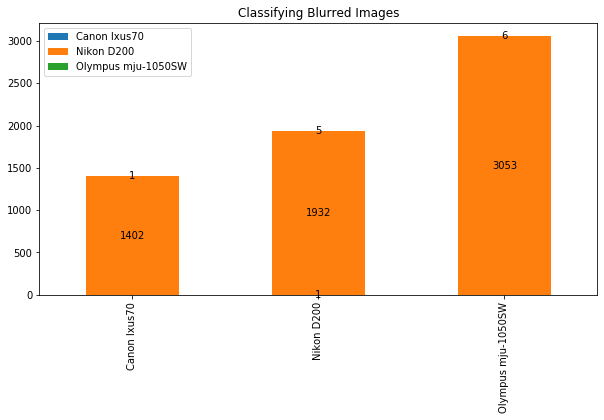

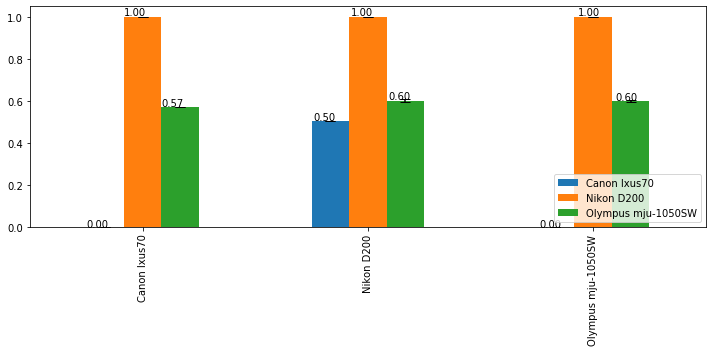

In [15]:
# Read the positive test samples.
blur_generator = test_data_gen.flow_from_directory(
                  directory = r"./post/blur/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# print('\n# Evaluate on test data')
# results = model.evaluate(blur_generator)

hist, conf, pred_labels, real_labels = func.evaluate(model_list, blur_generator, model, index=model_list, columns=model_list, 
                                           title='Classifying Blurred Images', num_batch=100, tex=True)

# df_mean, df_error = func.mean_error(conf, pred_labels, real_labels,
#                                     real_model=model_list, pred_model=model_list)

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
# df_mean.plot.bar(yerr=df_error, ax=axes[0,0], capsize=4)
# graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}

# func.plot_conf(conf, pred_labels, real_labels, graph, real_model=model_list, pred_model=model_list)
# plt.tight_layout()

tex = True
df_mean, df_error = func.mean_error(conf, pred_labels, real_labels,
                                    real_model=model_list, pred_model=model_list)
if tex:
    ax = df_mean.plot.bar(yerr=df_error, capsize=5, figsize=(10, 5))
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.008, p.get_height() * 1.008))
    tikzplotlib.save("test_conf.tex")    
else:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    ax = df_mean.plot.bar(yerr=df_error, ax=axes[0,0], capsize=4)
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.008, p.get_height() * 1.008))
    graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}
    func.plot_conf(conf, pred_labels, real_labels, graph, real_model=model_list, pred_model=model_list)
    
plt.tight_layout()